In [1]:
# -*-coding:utf-8 -*-
# import all the libraries 
# python==3.8; jupyterlab==3.0.12; lumicks.pylake==0.8.1; matplotlib==3.3.4; more-itertools==8.7.0;
# npTDMS==1.1.0; numpy==1.20.1; opencv-python==4.5.1.48; pandas==1.2.3; scipy==1.6.1; tifffile==2021.3.5
import os
import numpy as np
import cv2
import pylab as pl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import collections  as mc
from matplotlib import colors as mcolors
import pandas as pd
from nptdms import TdmsFile
from scipy.signal import savgol_filter
import tifffile as tif
from scipy import interpolate
from scipy.interpolate import interp1d
%matplotlib widget

In [2]:
# read raw image data of .tdms file with TdmsFile function
# kymo_filename = input('please type in the file name:' )
kymo_filename = 'example_dataset/image data/20190529-143510 30nM DNAp + trx  + 625uM dNTPs #012-001.tdms'

In [3]:
kymo_cycle = str('#') + input('please type in the processing cycle(e.g: 1):' )

In [4]:
# access .tdms file and convert .tdms to image data
metadata = TdmsFile.read_metadata(kymo_filename)
# print(metadata.properties)
width = metadata.properties['Pixels per line']
px_size = float(metadata.properties['Scan Command.Scan Command.scanning_axes.0.pix_size_nm'])
px_dwell_time = float(metadata.properties['Scan Command.PI Fast Scan Command.pixel_dwell_time_ms'])
inter_frame_time = float(metadata.properties['Scan Command.PI Fast Scan Command.inter_frame_wait_time_ms'])

tdms_file = TdmsFile(kymo_filename)
kymo_time = tdms_file['Data']['Time (ms)'][:]
kymo_time = np.array([int(i) for i in kymo_time])
kymo_position = tdms_file['Data']['Actual position X (um)'][:]
kymo_position = np.array([int(i) for i in kymo_position])
height = len(kymo_time)/width
time_per_line = kymo_time[-1]/height # this is calculated by (time_per_line = acquisition time/all lines)

chn_r = tdms_file['Data']['Pixel ch 1'][:]
chn_r = np.array([int(i) for i in chn_r])
chn_g = tdms_file['Data']['Pixel ch 2'][:]
chn_g = np.array([int(i) for i in chn_g])
chn_b = tdms_file['Data']['Pixel ch 3'][:]
chn_b = np.array([int(i) for i in chn_b])

chn_rgb = np.vstack((chn_r, chn_g, chn_b)).T
img = chn_rgb.reshape((int(height), int(width), 3))
img = img.transpose((1, 0, 2))
img = img.astype(np.uint16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


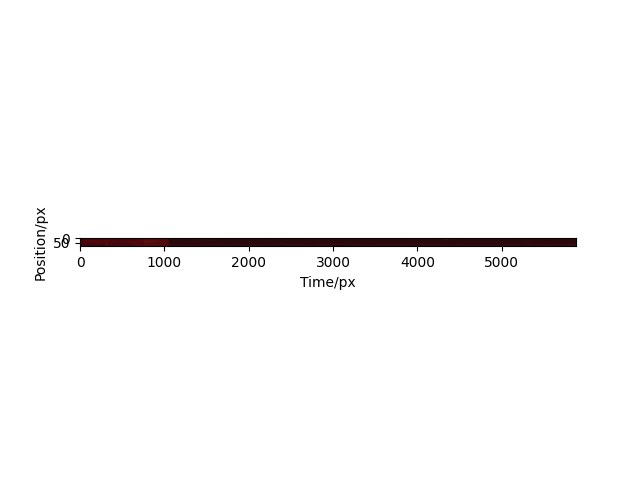

In [5]:
# show tif image
plt.figure(kymo_filename)
plt.imshow(img.astype('uint16'),vmax = 10)
plt.xlabel('Time/px')
plt.ylabel('Position/px')
plt.show()
plt.tight_layout()

In [6]:
# save .tdms file to tif image
tif.imwrite(kymo_filename + '.tiff', img)

Text(0, 0.5, 'Position/px')

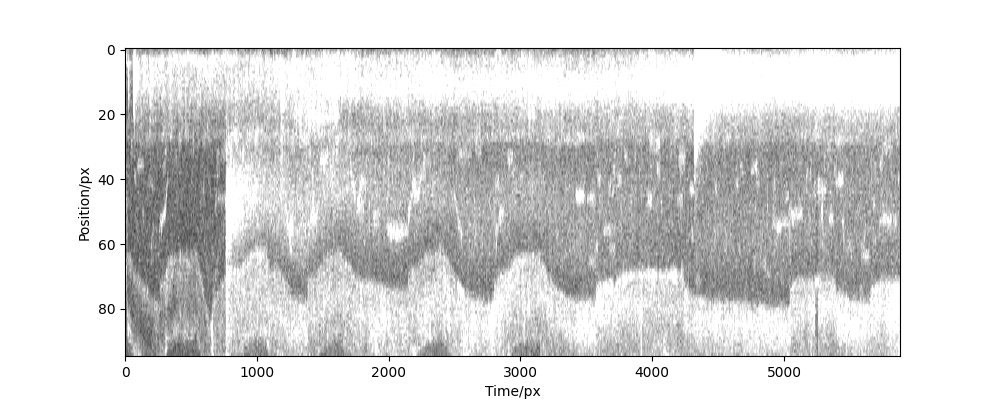

In [7]:
# Plot DNA polymerase from image data
b,g,r = cv2.split(img)

# the kymograph can be plotted in a normal image or in a reverse black-white image
vmax =12
fig, ax=plt.subplots(figsize=(10,4))
ax.imshow(g.astype('uint16'),cmap='gray',vmax = vmax,aspect ="auto")
# plt.imshow(100-g.astype('uint16'),cmap='gray',vmin = 95,aspect ="auto")

plt.xlabel("Time/px")
plt.ylabel("Position/px")
# plt.title("DNA Polymerase on ssDNA")

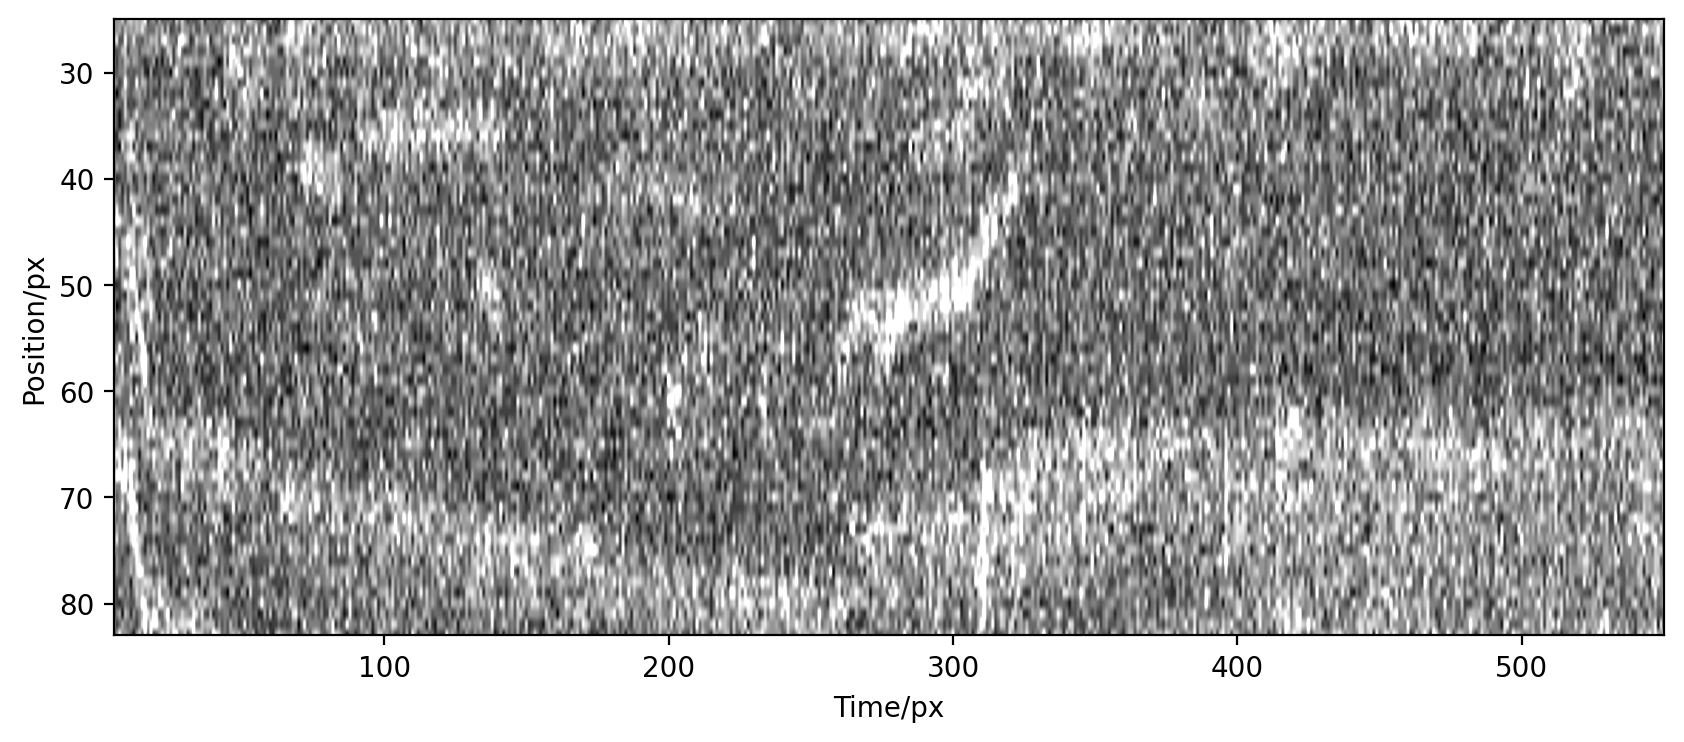

In [8]:
# this number defines the ROI (region of interest) of image in px; should be tuned to properly display the image

kymo_xlim_left = 5
kymo_xlim_right = 550
kymo_ylim_top = 25
kymo_ylim_bottom = 83

ax.set_xlim(kymo_xlim_left,kymo_xlim_right)
ax.set_ylim(kymo_ylim_bottom,kymo_ylim_top)
fig

In [9]:
# read and plot the DNA trace calculated from force measurement (1_CalculatingDNApTrace_OT.py)
# trace_file = input('please type in the file name:' )
trace_file = 'example_dataset/force data/20190529-143504 30nM DNAp + trx  + 625uM dNTPs #012-001-cycle#01processedData.xlsx'
trace = pd.read_excel(trace_file)
# trace = pd.read_excel(trace_file, engine='openpyxl')
print(trace.head())

   Unnamed: 0   time  ssDNA_all_percentage  junction_position_all    basepairs
0           0  10525              0.014124               0.066607  8274.454515
1           1  10571              0.013039               0.061487  8283.567336
2           2  10617              0.014466               0.068220  8271.584088
3           3  10663              0.013775               0.064959  8277.388239
4           4  10709              0.016578               0.078180  8253.857005


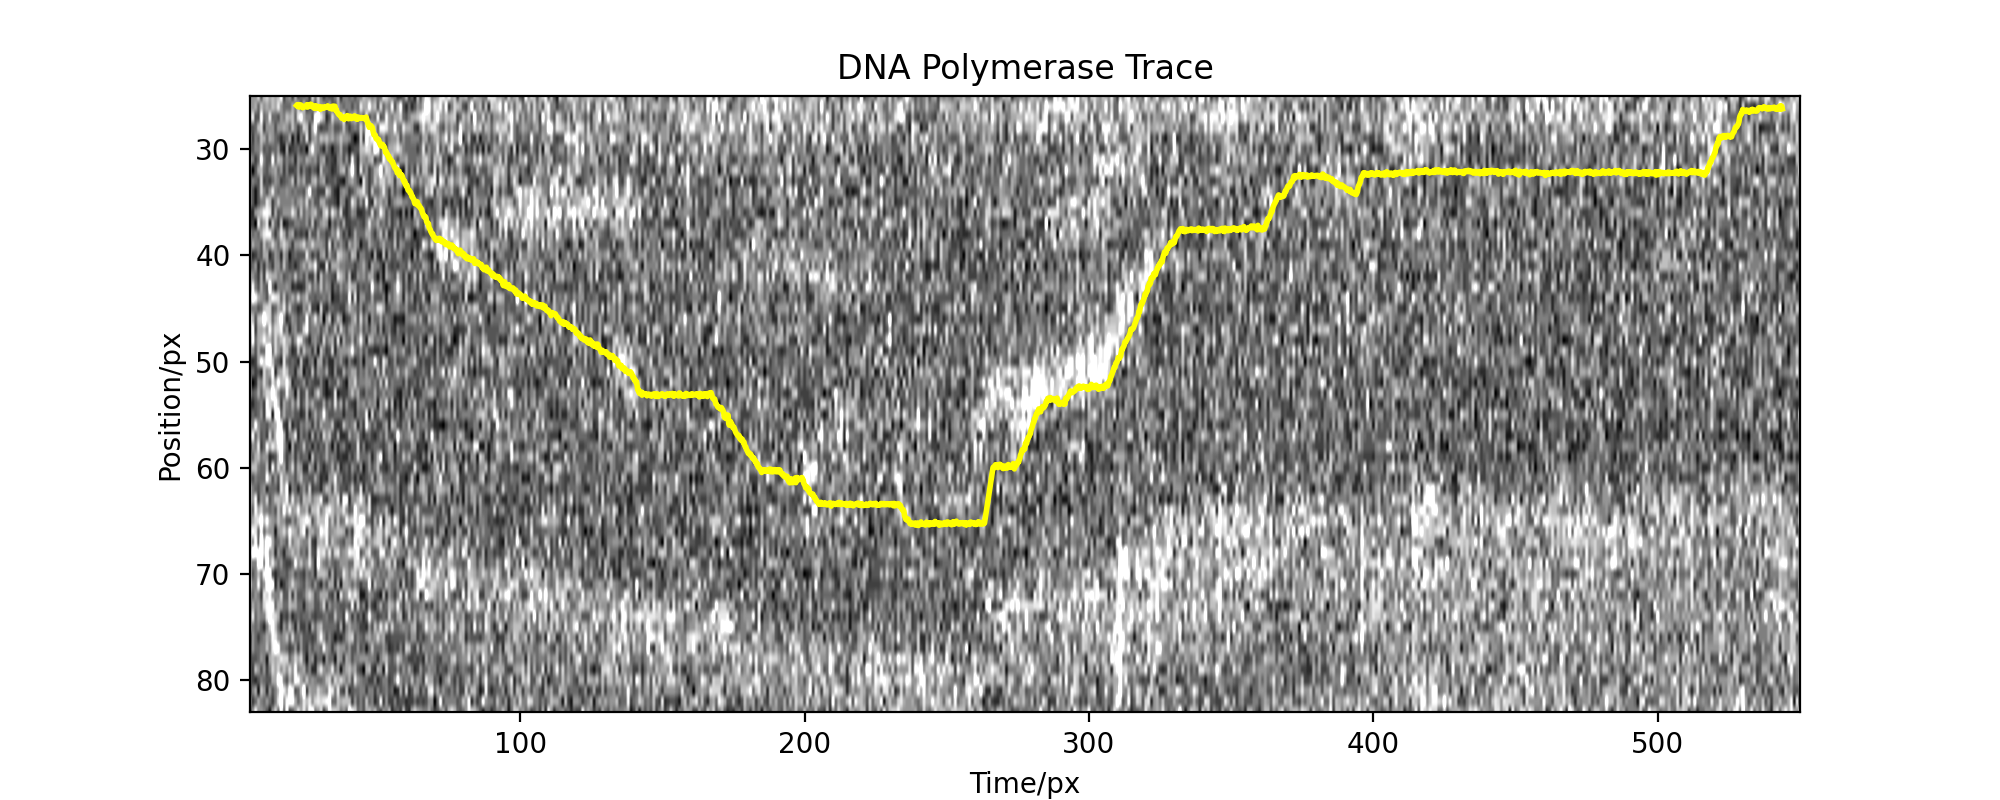

In [10]:
# the following step is intended to plot the DNA junction on top of DNAp trajectory
# The time of image is used for reference and displayed
# Tune x_offset and y_offset to get the proper alignment

plt.xlabel("Time/px")
plt.ylabel("Position/px")
plt.title("DNA Polymerase Trace")
x_offset_searching = -28 # this is done by align starting time in pixel （larger absolute value moves to left）
y_offset_searching = 25 # this is done by align starting position in pixel 
x_cali = 1000/time_per_line  # this is calculated by (1s/time per line， e.g.：163.8ms)
y_cali = 1000/px_size # this is calculated by (1um/pixel size, in this case pixlsize = 75nm)
trace_time = trace['time']/1000 * x_cali + x_offset_searching
trace_time = trace_time.dropna()
position = pd.to_numeric(trace['junction_position_all'], errors='coerce') 
position = position * y_cali + y_offset_searching
position = position.dropna()

ax.plot(trace_time,position,'yellow',linewidth = 2, label = 'first trial correlation')
# plt.ylim(25,85)
# plt.legend()
# plt.show()

# plt.savefig(kymo_path  + '-cycle' + kymo_cycle +'-overlap'+'.png', dpi=150)
plt.savefig(kymo_filename.replace('.tdms', '-cycle')+ kymo_cycle+'-overlap.eps', format='eps', dpi=300,bbox_inches='tight')
plt.show()

# In case after running the above code, you see the DNAp moving in an opposite direction, go back to step1 (1_CalculatingDNApTrace_OT.py) and recalculate the junction position

[-31]
[24]


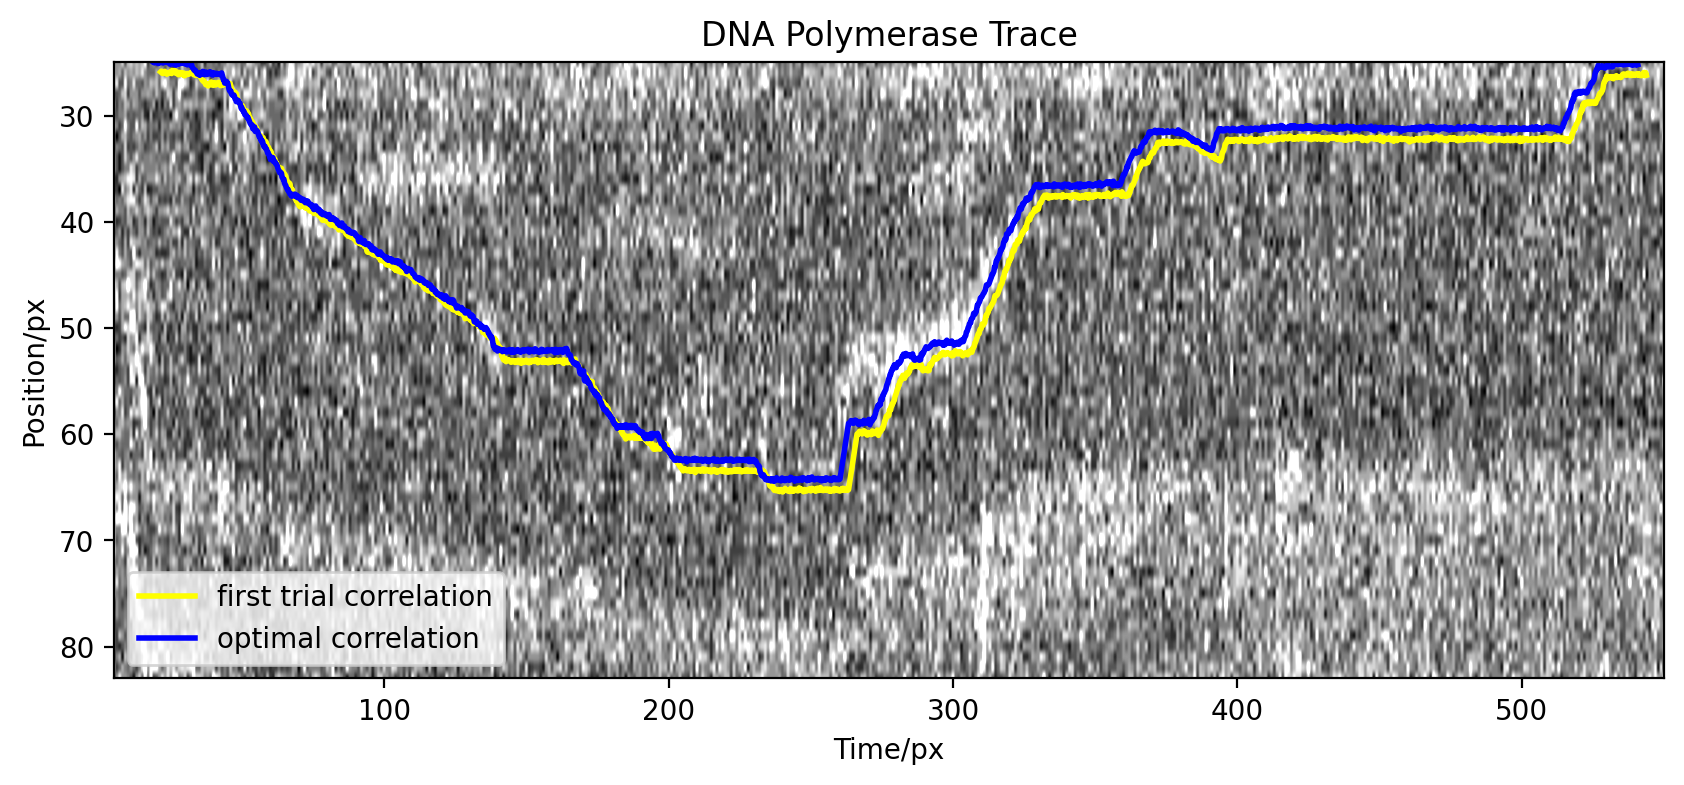

In [11]:
# this step is intended to automatically find the optimal x_offset and y_offset by searching in a confined space, 
# wiht a searching goal of maximizing the intensity along DNAp trace
x_offset_ls = []
y_offset_ls = []
intens_sum_ls = []
for i_x in np.arange(-5,6):
    for i_y in np.arange (-2,3):
        x_offset = x_offset_searching + i_x
        y_offset = y_offset_searching + i_y
        # print(x_offset,y_offset)
        trace_time = trace['time']/1000 * x_cali + x_offset
        trace_time = trace_time.dropna()
        position = pd.to_numeric(trace['junction_position_all'], errors='coerce') 
        position = position * y_cali + y_offset
        position = position.dropna()
        

        # In order to calculate the the intensity of protein trace as a function of time (px), we first need the locate the protein trace based on DNA trajectory
        # this is done by reading the coordinates (time, position) of protein trace in kymograph based on the overlapping of force data and image data.
        # Since the sampling rate is different between force data and image data, therefore interpolate is performed
        func = interpolate.interp1d(trace_time,position,kind='slinear',fill_value="extrapolate")

        # x defines the pixel in time
        # x = np.arange(round(trace_time.iloc[0]),round(trace_time.iloc[-1]))
        # to exclude part of the trajectory that is too close to the bright bead
        x = np.arange(round(trace_time.iloc[100]),round(trace_time.iloc[-1]))
        # x1 here traces back to time in unit of s
        x1 = (x-x_offset)/x_cali
        y = func(x)
        y = np.rint(y).astype(int)
        # the sum of the intensity along DNAp
        intens_sum = np.sum(g[y,x])
        
        x_offset_ls.append(x_offset)
        y_offset_ls.append(y_offset)
        intens_sum_ls.append(intens_sum)
        
x_offset_ls = np.array(x_offset_ls)       
y_offset_ls = np.array(y_offset_ls)
intens_sum_ls = np.array(intens_sum_ls)

# this step is to find out the index of the maximum value of intensity
intens_ind = np.where(intens_sum_ls[:] == np.amax(intens_sum_ls[:]))
x_offset_optimal = x_offset_ls[intens_ind]
y_offset_optimal = y_offset_ls[intens_ind]
print(x_offset_optimal)
print(y_offset_optimal)
trace_time = trace['time']/1000 * x_cali + x_offset_optimal
trace_time = trace_time.dropna()
position = pd.to_numeric(trace['junction_position_all'], errors='coerce') 
position = position * y_cali + y_offset_optimal
position = position.dropna()
ax.plot(trace_time,position,'b',linewidth = 2, label = 'optimal correlation')
ax.legend()   
fig
# plt.show()
# plt.savefig(kymo_path  + '-cycle' + kymo_cycle +'-overlap'+'.png', dpi=150)

In [12]:
# # In case the optimazation fails, you can manually set the optimal offset, otherwise don't run this code
# x_offset_optimal = x_offset_searching
# y_offset_optimal = y_offset_searching 

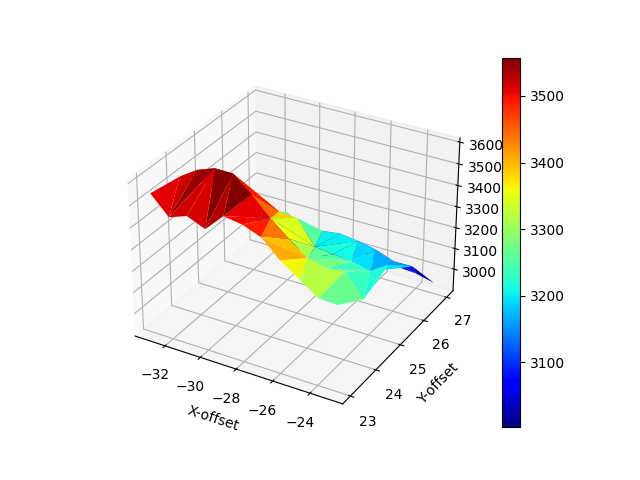

In [13]:
# the fllowing code is intended to plot the intensity as a function of x-offset and y-offset in 3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, linewidth=0)
surf = ax.plot_trisurf(x_offset_ls, y_offset_ls, intens_sum_ls, cmap=cm.jet, linewidth=0)
fig.colorbar(surf)
ax.set_xlabel('X-offset')
ax.set_ylabel('Y-offset')
ax.set_zlabel('Intensity of DNAp Trace')

plt.show()

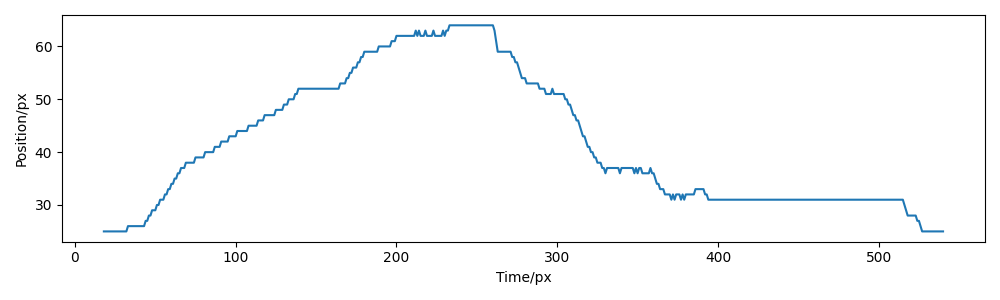

In [14]:
# In order to calculate the the intensity of protein trace as a function of time (px), we first need the locate the protein trace based on DNA trajectory
# this is done by reading the coordinates (time, position) of protein trace in kymograph based on the overlapping of force data and image data.
# Since the sampling rate is different between force data and image data, therefore interpolate is performed
func = interpolate.interp1d(trace_time,position,kind='slinear',fill_value="extrapolate")
# x defines the pixel in time
x = np.arange(round(trace_time.iloc[0]),round(trace_time.iloc[-1]))
# x1 here traces back to time in unit of s
x1 = (x-x_offset_optimal)/x_cali
y = func(x)
y = np.rint(y).astype(int)
plt.figure(figsize=(10,3))
plt.plot(x,y)
plt.xlabel("Time/px")
plt.ylabel("Position/px")
plt.tight_layout()
plt.show()


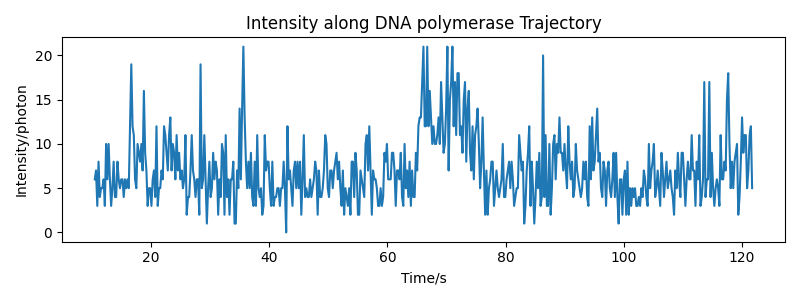

In [15]:
# this step is to plot the intensity on the axis of DNAp trace
# img has been split into 3 channels, b,g,r; so here green channel is used
ins = g[y,x]
plt.figure(figsize=(8,3))
plt.plot(x1,ins)
plt.xlabel("Time/s")
plt.ylabel("Intensity/photon")
plt.title("Intensity along DNA polymerase Trajectory")
plt.tight_layout()
# plt.ylim(0,30)
plt.show()

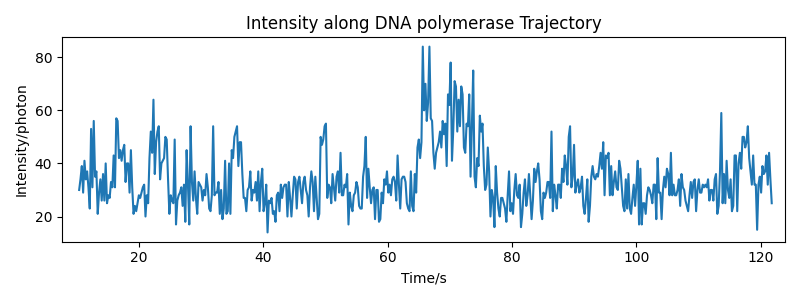

In [16]:
# sum up 5 pixels around DNAp trace
list = [y-2, y-1, y, y+1, y+2]
intensity = np.zeros((len(list),len(x)), dtype=int)
all_intensity = np.zeros((len(x),), dtype=int)
for i, value in enumerate(list):
    intensity[i] = g[value,x]
#     print(intensity)
    all_intensity += g[value,x]
    
# print(intensity)
# print(all_intensity)
plt.figure(figsize=(8,3))
plt.plot(x1,all_intensity)
plt.xlabel("Time/s")
plt.ylabel("Intensity/photon")
plt.title("Intensity along DNA polymerase Trajectory")
plt.tight_layout()
plt.xlim((kymo_xlim_left-x_offset_optimal)/x_cali,(kymo_xlim_right-x_offset_optimal)/x_cali)
# plt.ylim(0,70)
plt.show()

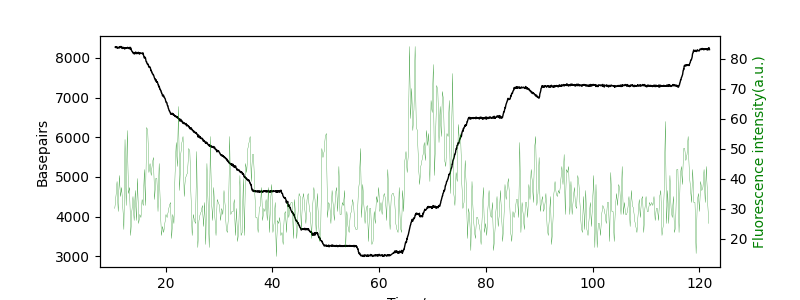

In [17]:
# this code block is intended to overlap the basepair-time and raw intensity -time plots
basepair = pd.read_excel(trace_file)
bp_time = basepair['time']/1000
bp_time = bp_time.dropna()
bp = basepair['basepairs']
bp = bp.dropna()

fig, ax1 = plt.subplots(figsize=(8,3))

ax2 = ax1.twinx()
ax1.plot(bp_time,bp,color='black',linewidth=1, label='basepairs')
ax1.set_xlabel('Time/s')
ax1.set_ylabel('Basepairs', color='black')

ax2.plot(x1,all_intensity,color='green',linewidth=0.2, label='fluorescence intensity')

ax2.set_ylabel('Fluorescence intensity(a.u.)', color='green')
plt.xlim((kymo_xlim_left-x_offset_optimal)/x_cali,(kymo_xlim_right-x_offset_optimal)/x_cali)
# plt.legend()
# plt.xlim(35,70)
plt.show()
plt.tight_layout()

plt.savefig(kymo_filename.replace('.tdms', '-cycle') + kymo_cycle + '-raw Bp -intensity along DNAp Trajectory'+'.eps', format='eps', dpi=300, bbox_inches='tight')

## To extract the DNAp-bound events

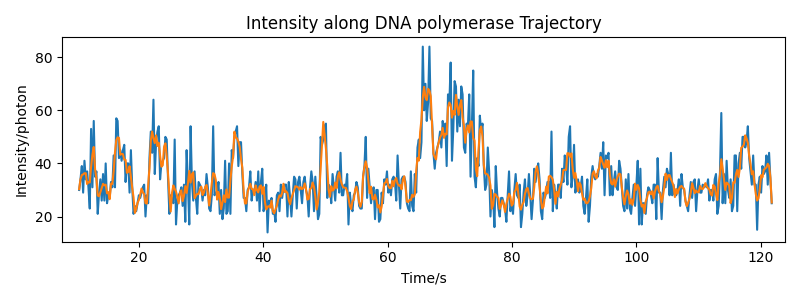

In [18]:
# Apply a Savitzky-Golay filter to an array.
signal = all_intensity
signal_filter_window = 7
signal_filter = savgol_filter(signal[:], signal_filter_window, 3) # filter window size of 47 gives us a sampling rate of 0.1HZ
# dt = x[1]-x[0]
# signal_filter_grad = np.gradient(signal_filter, dt)
# plt.figure()

plt.figure(figsize=(8,3))
plt.plot(x1,all_intensity)
plt.plot(x1,signal_filter)
plt.xlabel("Time/s")
plt.ylabel("Intensity/photon")
plt.title("Intensity along DNA polymerase Trajectory")
plt.tight_layout()
plt.xlim((kymo_xlim_left-x_offset_optimal)/x_cali,(kymo_xlim_right-x_offset_optimal)/x_cali)
# plt.ylim(0,30)
plt.show()

plt.savefig(kymo_filename.replace('.tdms', '-cycle') + kymo_cycle + 'Intensity along DNA polymerase Trajectory'+'.eps', format='eps', dpi=300, bbox_inches='tight')

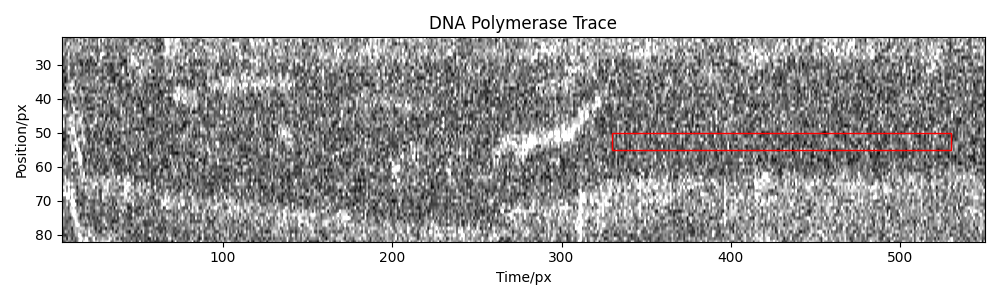

In [19]:
# the following code blocks are to find out the intensity of the background, by selecting a region in the kymopgraph and calculating the intensity
# step 1: selecting the ROI of background
plt.figure(figsize=(10,3))
# the kymograph can be plotted in a normal way or in a reverse way
# plt.imshow(g.astype('uint16'),cmap='gray',vmax = 10,aspect ="auto")
plt.imshow(g.astype('uint16'),cmap='gray',vmax = vmax,aspect ="auto")
currentAxis=plt.gca()
# for consistentence, background window is selected with a fixed size (5px * 200px)
rec_x,rec_y,rec_w,rec_h = [330,50,len(list),200]
rect=patches.Rectangle((rec_x,rec_y),rec_h,rec_w,linewidth=1,edgecolor='r',facecolor='none',fill=False)
currentAxis.add_patch(rect)

plt.xlabel("Time/px")
plt.ylabel("Position/px")
plt.title("DNA Polymerase Trace")
plt.ylim(82,22)
plt.xlim(kymo_xlim_left,kymo_xlim_right)
# plt.xlim(0,560)
plt.tight_layout()

plt.savefig(kymo_filename.replace('.tdms', '-cycle') + kymo_cycle + '-background Intensity'+'.eps', format='eps', dpi=300, bbox_inches='tight')
# plt.close()

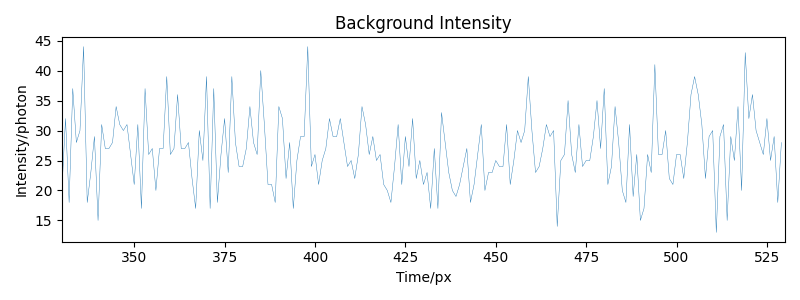

In [20]:
# step 2: calculating the intensity of the background
list = [rec_y,rec_y+1,rec_y+2,rec_y+3,rec_y+4]
rec_x_list = np.arange(rec_x, rec_x+rec_h)
bagrnd_intensity = np.zeros((rec_w,len(rec_x_list)), dtype=int)
bagrnd_all_intensity = np.zeros((len(rec_x_list),), dtype=int)
for i, value in enumerate(list):
    bagrnd_intensity[i] = g[value,rec_x_list]
#     print(intensity)
    bagrnd_all_intensity += g[value,rec_x_list]


fig, ax=plt.subplots(figsize=(8,3))
ax.plot(rec_x_list,bagrnd_all_intensity,linestyle='solid',linewidth=0.3, markersize=0.5,label='Background Signal')

ax.set_xlim(rec_x,rec_x+rec_h)
ax.set_xlabel("Time/px")
ax.set_ylabel("Intensity/photon")
ax.set_title("Background Intensity")
plt.tight_layout()
# plt.ylim(0,30)
# plt.show()

In [21]:
# Apply a Savitzky-Golay filter to an array.
bagrnd_filter_window = 25
threshold_sigma  = 3

bagrnd_signal = bagrnd_all_intensity 
bagrnd_signal_filter = savgol_filter(bagrnd_signal[:], bagrnd_filter_window, 3) # filter window size of 25 gives us a sampling rate of 0.2HZ
# dt = x[1]-x[0]
# signal_filter_grad = np.gradient(signal_filter, dt)
# plt.figure()
ax.plot(rec_x_list,bagrnd_signal_filter,linestyle='solid',linewidth=1, markersize=1,label='Background Signal Filter')
ax.axline((x[0], np.average(bagrnd_signal_filter)), (x[-1], np.average(bagrnd_signal_filter)),color = 'yellow',label='Background Signal Filter Mean')

# plt.axhline(np.average(bagrnd_signal_filter)+np.std(bagrnd_signal_filter), color='r', linestyle='--',label='1 sigma')
# plt.axhline(np.average(bagrnd_signal_filter)-np.std(bagrnd_signal_filter), color='r', linestyle='--')
ax.axhline(np.average(bagrnd_signal_filter)+threshold_sigma*np.std(bagrnd_signal_filter), color='k', linestyle='--',label= str(threshold_sigma) + ' Sigma&filterSize ' + str(bagrnd_filter_window))
ax.axhline(np.average(bagrnd_signal_filter)-threshold_sigma*np.std(bagrnd_signal_filter), color='k', linestyle='--')

# plt.ylim(0,80)
ax.set_xlim(rec_x,rec_x+rec_h)
ax.legend(loc='upper right')
fig
# plt.tight_layout()

plt.savefig(kymo_filename.replace('.tdms', '-cycle') + kymo_cycle + 'background Intensity along DNA polymerase Trajectory'+'.eps', format='eps', dpi=300, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


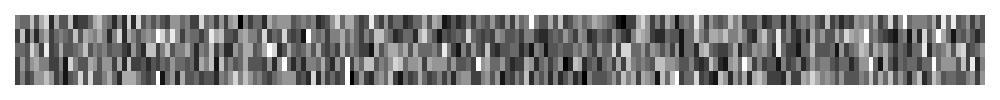

In [22]:
plt.figure(figsize=(10,1))
# print(image)
# plt.imshow(intensity.astype('uint8'),aspect ="auto")
plt.imshow(bagrnd_intensity.astype('uint8'),cmap='gray',vmax = vmax,interpolation='nearest', aspect='auto')

plt.axis('off')
# plt.xlim(0, )
plt.tight_layout()
# plt.ylim(0,7)
plt.savefig(kymo_filename.replace('.tdms', '-cycle')  + kymo_cycle + '-Background Intensity'+'.png', dpi=150)

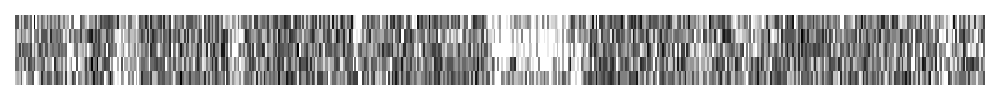

In [23]:
plt.figure(figsize=(10,1))
# print(image)
# plt.imshow(intensity.astype('uint8'),aspect ="auto")
plt.imshow(intensity.astype('uint8'),cmap='gray',vmax = vmax,interpolation='nearest', aspect='auto')

plt.axis('off')
# plt.xlim(0, )
plt.tight_layout()
# plt.ylim(0,7)
plt.savefig(kymo_filename.replace('.tdms', '-cycle') + kymo_cycle + '-Squeezed DNAp Trace'+'.png', dpi=150)

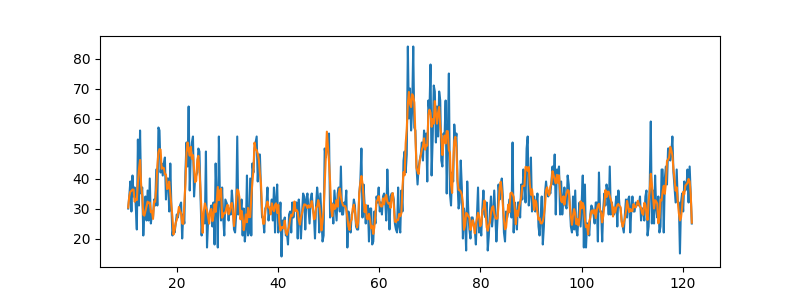

In [24]:
plt.figure(figsize=(8,3))
plt.plot(x1,all_intensity)
plt.plot(x1,signal_filter)
plt.show()

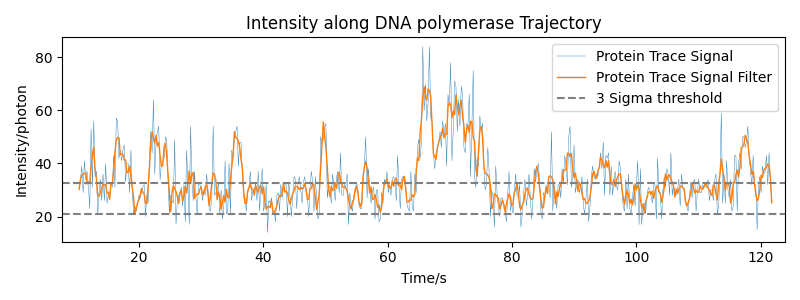

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


32.63319310602289


In [25]:
# plot the DNAP intensity in a raw data, filtered data

plt.figure(figsize=(8,3))
# plt.plot(rec_x_list,bagrnd_signal_filter,linestyle='solid',linewidth=1, markersize=1,label='Background Signal Filter')
plt.plot(x1,all_intensity,linestyle='solid',linewidth=0.3, markersize=0.5,label='Protein Trace Signal')
plt.plot(x1,signal_filter,linestyle='solid',linewidth=1, markersize=0.5,label='Protein Trace Signal Filter')
# plt.plot(x1,data_stepfinder['FinalFit'],color='black',linewidth=1, label='Step Fit')
# plt.axhline(np.average(bagrnd_signal_filter),color = 'b',label='Background Signal Filter Mean')
# plt.axhline(np.average(bagrnd_signal_filter)+np.std(bagrnd_signal_filter), color='r', linestyle='--',label='1 sigma')
plt.axhline(np.average(bagrnd_signal_filter)+threshold_sigma*np.std(bagrnd_signal_filter), color='grey', linestyle='--',label=str(threshold_sigma) + ' Sigma threshold')
plt.axhline(np.average(bagrnd_signal_filter)-threshold_sigma*np.std(bagrnd_signal_filter), color='grey', linestyle='--')

plt.xlabel("Time/s")
plt.ylabel("Intensity/photon")
plt.title("Intensity along DNA polymerase Trajectory")
plt.legend()
plt.tight_layout()
plt.xlim((kymo_xlim_left-x_offset_optimal)/x_cali,(kymo_xlim_right-x_offset_optimal)/x_cali)
# plt.xlim(32,40)
# plt.ylim(3500,6000)
# plt.ylim((0,60))
plt.show()

plt.savefig(kymo_filename.replace('.tdms', '-cycle') + kymo_cycle + 'Intensity along DNA polymerase Trajectory-1'+'.eps', format='eps', dpi=300, bbox_inches='tight')
print(np.average(bagrnd_signal_filter)+threshold_sigma*np.std(bagrnd_signal_filter))

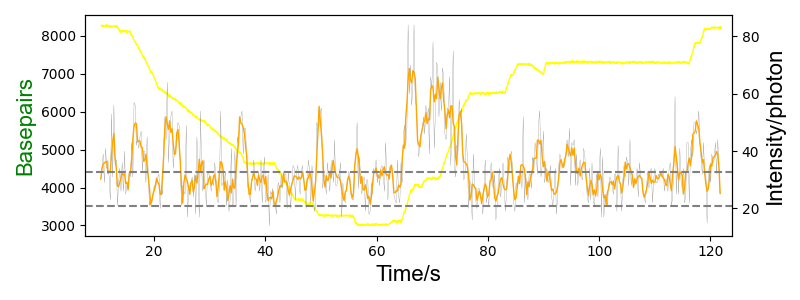

32.63319310602289


In [29]:
# plot the DNAP intensity in a raw data, filtered data and overlap the basepair-time

basepair = pd.read_excel(trace_file)
bp_time = basepair['time']/1000
bp_time = bp_time.dropna()
bp = basepair['basepairs']
bp = bp.dropna()

fig, ax1 = plt.subplots(figsize=(8,3))
font = {'family': 'Arial', 'weight': 'normal', 'size': 16}

ax2 = ax1.twinx()
ax1.plot(bp_time,bp,color='yellow',linewidth=1, label='basepairs')
ax1.set_xlabel('Time/s',fontdict=font)
ax1.set_ylabel('Basepairs', color='green',fontdict=font)

ax2.plot(x1,all_intensity,color='gray',linestyle='solid',linewidth=0.2, markersize=0.5,label='Protein Trace Signal')
ax2.plot(x1,signal_filter,color='orange',linestyle='solid',linewidth=1, markersize=0.5,label='Protein Trace Signal Filter')
ax2.axhline(np.average(bagrnd_signal_filter)+threshold_sigma*np.std(bagrnd_signal_filter), color='grey', linestyle='--',label=str(threshold_sigma) + ' Sigma threshold')
ax2.axhline(np.average(bagrnd_signal_filter)-threshold_sigma*np.std(bagrnd_signal_filter), color='grey', linestyle='--')

ax2.set_xlabel("Time/s",fontdict=font)
ax2.set_ylabel("Intensity/photon", color='black',fontdict=font)


plt.xlim((kymo_xlim_left-x_offset_optimal)/x_cali,(kymo_xlim_right-x_offset_optimal)/x_cali)

# plt.legend()
# plt.xlim(20,26)

# plt.title("Intensity along DNA polymerase Trajectory")
plt.tight_layout()
plt.show()

plt.savefig(kymo_filename.replace('.tdms', '-cycle') + kymo_cycle + 'Intensity along DNA polymerase Trajectory'+'.eps', format='eps', dpi=300, bbox_inches='tight')
print(np.average(bagrnd_signal_filter)+threshold_sigma*np.std(bagrnd_signal_filter))
# plt.close()

In [27]:
# this data block is used to save the intensity data for change-point detection
data_1 = {'time serials':x1,
          'raw intensity':all_intensity }
data_2 = {'time serials':x1,
          'filtered intensity':signal_filter}
# data_3 = {'time serials':x1,
#           'filtered s/n':loc_sig_noi}

df1 = pd.DataFrame(data_1)
df2 = pd.DataFrame(data_2)
# df3 = pd.DataFrame(data_3)

np.savetxt(kymo_filename.replace('.tdms', '-cycle') + kymo_cycle + '-Intensity along DNAp' + '-filtered' +'.txt', df2.values, fmt='%1.3f')


In [28]:
pause

NameError: name 'pause' is not defined

##### Now we are switching to Matlab. Here we are using AutoStepfinder (https://doi.org/10.1016/j.patter.2021.100256.) to detect the step behavior of fluorescence intensity of DNAp. Please refer to the user mannual of AutoStepfinder to find the optimal parameter for this algrithm
##### After running the code block below, a matlab window will pop put if everything is set correctly; if not, double check with the readme file.

#### Alternatively, one can also start Matlab program seperately, instead of using this combined code to avoid issues

In [ ]:
# when running the matlab API code, please ensure all the folder and subfolder are added to path
# you can check it by enter path in the Matlab commond window
import matlab.engine
eng = matlab.engine.start_matlab()
# you must add nargout=0 to run .m script, otherwise it will run as a function, see https://nl.mathworks.com/matlabcentral/answers/816065-execution-of-script-vgg16-as-a-function-is-not-supported
eng.AutoStepfinder(nargout=0)

### An example of settings:
- Data Path (IMPORTANT!): The Data Path here shoule be the dataset direcory, rather than subfolders
- S-curves,User plot, advanced Options, Custom Output are set as on.
- After running the code, use mannual mode to find a better number of steps, in case you are not satisfied with the automatic results
- write down how many steps you fit to the data and revise it in the analysis log file in the final code block

In [30]:
txtpath_AutoStepfinder = os.path.join(os.path.dirname(kymo_filename), "StepFit_Result/image data-cycle#1-Intensity along DNAp-filtered_fits.txt")
data_stepfinder = pd.read_csv(txtpath_AutoStepfinder, sep=",", skipinitialspace = True)
# print(data_stepfinder)
# changepoint_index = np.array(data_stepfinder['Time'])
# print(changepoint_index)

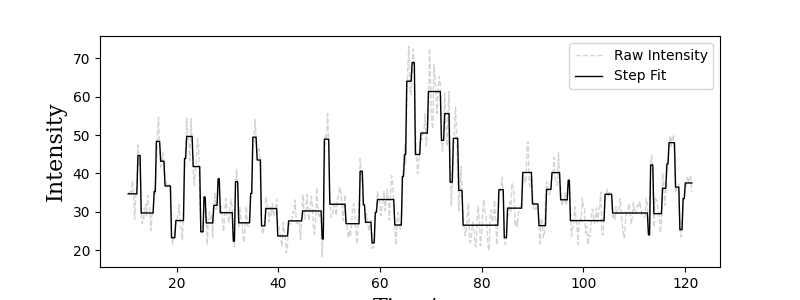

In [31]:
# plot the change-points on the basepair plot
plt.figure(figsize=(8,3))
font = {'family': 'serif',
        'weight': 'normal',
        'size': 16}

plt.xlabel('Time/s',fontdict=font)
plt.ylabel('Intensity',fontdict=font)
plt.plot(x1[:-2],data_stepfinder['Data'],color='lightgray', linestyle='dashed',linewidth=1, label='Raw Intensity')
plt.plot(x1[:-2],data_stepfinder['FinalFit'],color='black',linewidth=1, label='Step Fit')
# plt.axhline(1.3, color='grey', linestyle='--')
plt.legend()
# plt.ylim(0,30)

plt.show()
plt.tight_layout()
plt.savefig(kymo_filename.replace('.tdms', '-cycle') + kymo_cycle + '-Step Intensity along DNAp'+'.png', dpi=300)

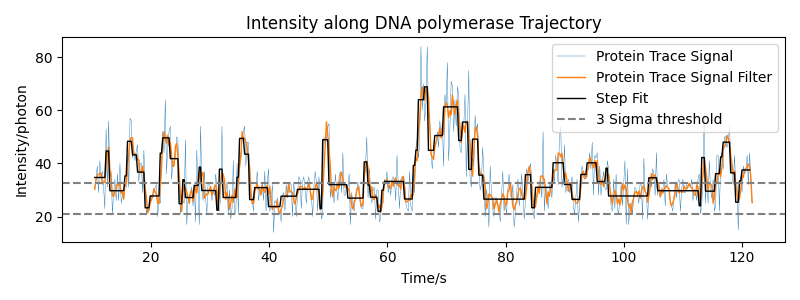

26.774788405797043


In [32]:
# plot the DNAP intensity in a raw data, filtered data and step-fitted data style

plt.figure(figsize=(8,3))
# plt.plot(rec_x_list,bagrnd_signal_filter,linestyle='solid',linewidth=1, markersize=1,label='Background Signal Filter')
plt.plot(x1,all_intensity,linestyle='solid',linewidth=0.3, markersize=0.5,label='Protein Trace Signal')
plt.plot(x1,signal_filter,linestyle='solid',linewidth=1, markersize=0.5,label='Protein Trace Signal Filter')
plt.plot(x1[:-2],data_stepfinder['FinalFit'],color='black',linewidth=1, label='Step Fit')
# plt.axhline(np.average(bagrnd_signal_filter),color = 'b',label='Background Signal Filter Mean')
# plt.axhline(np.average(bagrnd_signal_filter)+np.std(bagrnd_signal_filter), color='r', linestyle='--',label='1 sigma')
plt.axhline(np.average(bagrnd_signal_filter)+threshold_sigma*np.std(bagrnd_signal_filter), color='grey', linestyle='--',label=str(threshold_sigma) + ' Sigma threshold')
plt.axhline(np.average(bagrnd_signal_filter)-threshold_sigma*np.std(bagrnd_signal_filter), color='grey', linestyle='--')

plt.xlabel("Time/s")
plt.ylabel("Intensity/photon")
plt.title("Intensity along DNA polymerase Trajectory")
plt.legend()
plt.tight_layout()
# plt.xlim((kymo_xlim_left,kymo_xlim_right))
# plt.ylim((0,35))
plt.show()
plt.savefig(kymo_filename.replace('.tdms', '-cycle') + kymo_cycle + '-Intensity along DNA polymerase Trajectory'+'.png', dpi=150)  
print(np.average(bagrnd_signal_filter))

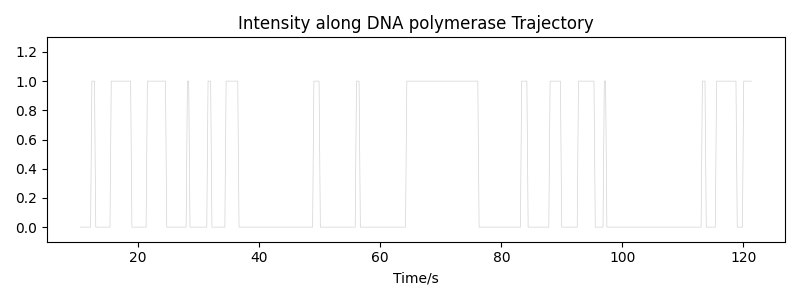

In [33]:
# Binarize the intensity with a given threshold, which is used to be 3~5. 
# Here we used a bit higher sigma to exclude the potential noise. Please tune this parameter based on your data
threshold = np.mean(bagrnd_signal_filter)+ (threshold_sigma+1.1)*np.std(bagrnd_signal_filter)
upper, lower = 1, 0
# signal_filter_binarized = np.where((data_stepfinder['FinalFit']>threshold) & (loc_sig_noi>1.3), upper, lower)
signal_filter_binarized = np.where(data_stepfinder['FinalFit']>threshold, upper, lower)
# signal_filter_binarized = np.where(loc_sig_noi>1.2, upper, lower)

plt.figure(figsize=(8,3))
plt.xlabel("Time/s")
# plt.ylabel("Binarized Intensity")
plt.plot(x1[:-2],signal_filter_binarized,color='lightgrey',linewidth=0.5)
# plt.legend()
plt.ylim(-0.1,1.3)
# plt.xlim(32,60)
# plt.xlim((kymo_xlim_left-x_offset_optimal)/x_cali,(kymo_xlim_right-x_offset_optimal/x_cali)
plt.title("Intensity along DNA polymerase Trajectory")
plt.tight_layout()
plt.show()
plt.savefig(kymo_filename.replace('.tdms', '-cycle')+ kymo_cycle + '-Intensity along DNA polymerase Trajectory-binarized'+'.png', dpi=150)

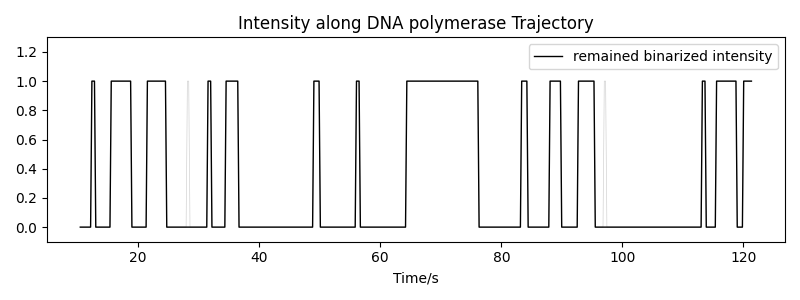

In [34]:
# this step intended to filter those short bound and short unbound events due to noise, with a (default) threshold of 2-3 adjacent fluorescent dots, which corresponds to ~0.2s
# you could increase the threhold to filter more events. Please tune this parameter for your data

signal_filter_binarized = np.insert(signal_filter_binarized,0,0)
signal_filter_binarized = np.append(signal_filter_binarized,0)
signal_filter_binarized_diff = np.diff(signal_filter_binarized)
# print(signal_filter_binarized)
# print(signal_filter_binarized_diff)
index_on = np.where(signal_filter_binarized_diff==1)[0]
index_off = np.where(signal_filter_binarized_diff==-1)[0]
# print(index_on)
# print(index_off)
# print(index_on[1:] - index_off[:-1])
# this intended to filter those short bound events
for i, value in enumerate((index_off - index_on)):
    if value ==1:
        signal_filter_binarized[index_on[i] + 1] = 0
    if value ==2:
        signal_filter_binarized[index_on[i] + 1] = 0
        signal_filter_binarized[index_on[i] + 2] = 0
    # if value ==3:
    #     signal_filter_binarized[index_on[i] + 1] = 0
    #     signal_filter_binarized[index_on[i] + 2] = 0
    #     signal_filter_binarized[index_on[i] + 3] = 0

# this intended to filter those short unbound events
for i, value in enumerate((index_on[1:] - index_off[:-1])):
    if value ==1:
        signal_filter_binarized[index_off[i] + 1] = 1
    if value ==2:
        signal_filter_binarized[index_off[i] + 1] = 1
        signal_filter_binarized[index_off[i] + 2] = 1
    # if value ==3:
    #     signal_filter_binarized[index_off[i] + 1] = 1
    #     signal_filter_binarized[index_off[i] + 2] = 1
    #     signal_filter_binarized[index_off[i] + 3] = 1
    
signal_filter_binarized = np.delete(signal_filter_binarized,0)
signal_filter_binarized = np.delete(signal_filter_binarized,-1)
# print(signal_filter_binarized)
# plt.figure(figsize=(8,3))

plt.plot(x1[:-2],signal_filter_binarized,label = "remained binarized intensity",color='black',linewidth=1)
plt.legend(loc = "upper right")
plt.show()
plt.savefig(kymo_filename.replace('.tdms', '-cycle') + kymo_cycle + '-filtered and binirized intensity'+'.png', dpi=150)

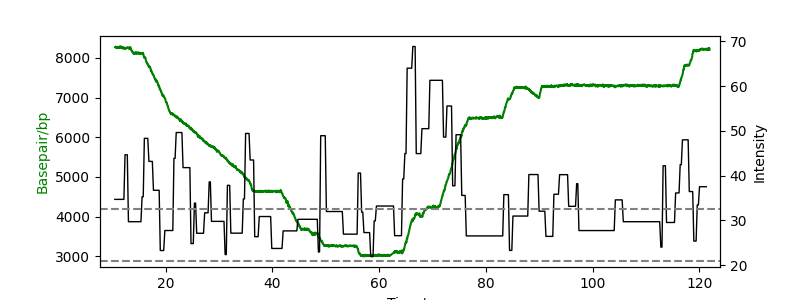

In [35]:
# this code block is intended to overlap the basepair-time and binarized intensity -time plots
basepair = pd.read_excel(trace_file)
bp_time = basepair['time']/1000
bp_time = bp_time.dropna()
bp = basepair['basepairs']
bp = bp.dropna()

fig, ax1 = plt.subplots(figsize=(8,3))

ax2 = ax1.twinx()
ax1.plot(bp_time,bp, 'g-',label = 'basepairs')
# ax2.plot(x1-0.2,signal_filter_binarized,color='lightgray',linewidth=1, label='binarized intensity')
# ax2.set_ylim(-0.02,1.05)
ax1.set_xlabel('Time/s')
# ax1.set_ylim(2000,5000)
ax1.set_ylabel('Basepair/bp', color='g')

ax2.plot(x1[:-2],data_stepfinder['FinalFit'],color='black',linewidth=1, label='step-like intensity')
# ax2.set_ylim(5,40)
plt.axhline(np.average(bagrnd_signal_filter)+threshold_sigma*np.std(bagrnd_signal_filter), color='grey', linestyle='--',label=str(threshold_sigma) + ' Sigma threshold')
plt.axhline(np.average(bagrnd_signal_filter)-threshold_sigma*np.std(bagrnd_signal_filter), color='grey', linestyle='--')


ax2.set_ylabel('Intensity', color='black')

# plt.plot(bp_time,bp,'y',linewidth = 1, label = 'basepairs')
# plt.plot(x1,signal_filter_binarized, label='Binarized Intensity')
# plt.legend()
# plt.ylim(25,85)
plt.xlim((kymo_xlim_left-x_offset_optimal)/x_cali,(kymo_xlim_right-x_offset_optimal)/x_cali)
# plt.xlim(35,70)
plt.show()
plt.tight_layout()
plt.savefig(kymo_filename.replace('.tdms', '-cycle')+ kymo_cycle + '-raw basepairs-Binarized intensity'+'.png', dpi=150)

/var/folders/7s/4zb5dg7n24q8rnf1200rm98r0000gn/T/ipykernel_4672/2353562566.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (8, 3))


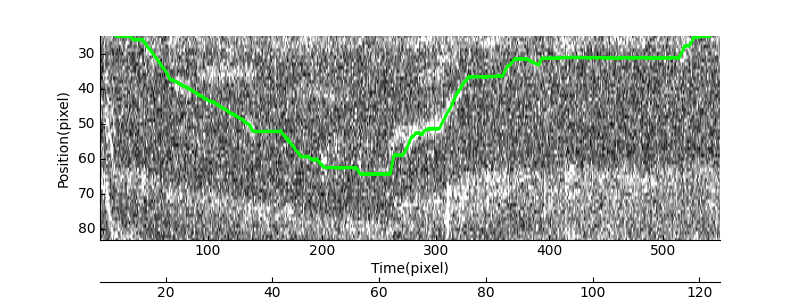

In [36]:
# This step is to get a double x-axis figure, which shows both time in unit of pixel and s [ref. https://matplotlib.org/2.0.2/examples/axes_grid/demo_parasite_axes2.html]
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

plt.figure(figsize = (8, 3))
font = {'family': 'Arial', 'weight': 'normal', 'size': 16}
#Setup a host axis
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(bottom=0.2)

#Add twin y axis with offset from bottom and hide top axis
par = host.twiny()
offset = -30
new_fixed_axis = host.get_grid_helper().new_fixed_axis
par.axis["bottom"] = new_fixed_axis(loc="bottom",
                                    axes=par,
                                    offset=(0, offset))

par.axis["top"].set_visible(False)
host.axis["right"].set_visible(False)

# Plot data and add main axis labels/limits; the kymograph can be plotted in a normal way or in a reverse way
host.imshow(g.astype('uint16'),cmap='gray',vmax = vmax,aspect ="auto")
# host.imshow(100-g.astype('uint16'),cmap='gray',vmin = 95,aspect ="auto")

host.set_xlabel("Time(pixel)",fontdict=font)
host.set_ylabel("Position(pixel)",fontdict=font)
# host.set_title("DNA Polymerase Trace",fontdict=font)
host.set_xlim((kymo_xlim_left,kymo_xlim_right))
# host.set_xlim((0,350))
host.set_ylim((kymo_ylim_bottom,kymo_ylim_top))
# host.invert_yaxis()
# host.invert_xaxis()
# plt.axis("tight")

#Set limits of parasite axis 
#(note this axis is not attached to 
# an actual plot so changes nothing)

par.set_xlabel("Time(s)",fontdict=font)
par.set_xlim((kymo_xlim_left-x_offset_optimal)/x_cali,(kymo_xlim_right-x_offset_optimal)/x_cali)

plt.plot(trace_time,position,'lime',linewidth = 2)
# ax.set_xlim(kymo_xlim_left,kymo_xlim_right)
# ax.set_ylim(kymo_ylim_bottom,kymo_ylim_top)

plt.show()
plt.tight_layout()

plt.savefig(kymo_filename.replace('.tdms', '-cycle') + kymo_cycle + '-DNA Polymerase Trace-2'+'.eps', format='eps', dpi=300, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


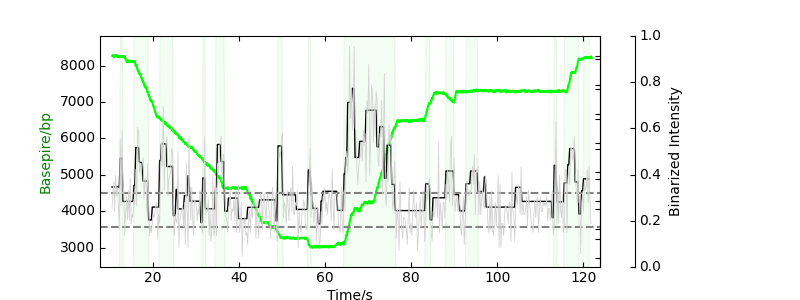

In [37]:
# This step is to get a three y-axis figure, which shows basepairs, raw intensity and binarized intensity
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

plt.figure(figsize=(8,3))
font = {'family': 'Arial', 'weight': 'normal', 'size': 16}

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()
par3 = host.twinx()

offset = 25
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right", axes=par2,
                                        offset=(offset, 0))

par2.axis["right"].toggle(all=True)

host.set_xlim((kymo_xlim_left-x_offset_optimal)/x_cali,(kymo_xlim_right-x_offset_optimal)/x_cali)
# host.set_ylim(1500,9000)

host.set_xlabel("Time/s",fontdict=font)
host.set_ylabel("Basepire/bp",fontdict=font)
# host.set_ylabel("DNAp Activity Burst")
par1.set_ylabel("Step-like Intensity",fontdict=font)
par2.set_ylabel("Binarized Intensity",fontdict=font)

p0, = host.plot(bp_time,bp, "lime",label = 'Basepairs',linewidth=1.5)
# p0, = host.plot(bp_time[:-2],np.diff(cp_basepair_interp)/np.diff(bp_time),"red", label = "DNAp Activity Burst",linewidth = 1)
p1, = par1.plot(x1[:-2],data_stepfinder['FinalFit'],color='black',linewidth=1, label='Step-like intensity')
p2, = par2.plot(x1[:-2],signal_filter_binarized,color='lightgray',linewidth=0.1, label='Binarized Intensity')
par2.fill_between(x1[:-2],signal_filter_binarized, 0, color='lightgreen',alpha=0.1)
p3, = par3.plot(x1,all_intensity,color='lightgray',linewidth=0.6, linestyle='solid', markersize=0.5,label='Raw Intensity')


colors = [mcolors.to_rgba(c)
          for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
# lc = mc.LineCollection(segments, colors=colors, linewidths=3)
# host.add_collection(lc)
host.autoscale()
host.margins(0.1)

par1.axhline(np.average(bagrnd_signal_filter)+threshold_sigma*np.std(bagrnd_signal_filter), color='grey', linestyle='--',label=str(threshold_sigma) + ' Sigma threshold')
par1.axhline(np.average(bagrnd_signal_filter)-threshold_sigma*np.std(bagrnd_signal_filter), color='grey', linestyle='--')

par1.set_ylim(7, 87)
par2.set_ylim(0, 1)

# host.legend()


host.axis["left"].label.set_color('green')
par1.axis["right"].label.set_color(p1.get_color())
par2.axis["right"].label.set_color(p1.get_color())

# plt.draw()
# Set the legend outside the plot
# plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1))

## Adjust the plot size to fit the legend
# plt.subplots_adjust(right=0.5)
# plt.xlim(20,26)
# plt.show()
# plt.tight_layout()

plt.savefig(kymo_filename.replace('.tdms', '-cycle') + kymo_cycle + '-all_correlated-zoomin'+'.eps', format='eps', dpi=300)

## After analyzing the intensity data, let's show the basepair data in a more clear way, by visualizing the burst of DNAp activity in  different colors.
##### Now we are switching to Matlab again. Here we are using another change-point detection algrithm, based on a previous publication(Kerssemakers, J.,et al.Nature, 2006) with further customerized features contributed by Noemie.B.Danne (n.b.danne@vu.nl) and Longfu Xu (l2.xu@vu.nl). Please refer to the publication to understand this algrithm before using
##### After running the code block below, a matlab window of results will pop put if everything is set correctly; if not, double check with the readme file.
#### One common issue is that decimal point should be changed to comma, instead of a dot (This is caused by saving the tweezer data in a different version of python)
##### Please review the fitted results and tuning the parameters to get an optimal results
- write down the window size and sigma value you are using in this step, and revise it in the analysis log file in the final code block

In [38]:
# Here you can edit the MatLab code with the pop-out window if you are not satisfized with the results.
# You should check the Pathname, Filename,FolderSave to ensure you are selecting the right data to analyze
# You can tune the filter window size and sigma value to get an optimal fitting results.
# After changing these arguments, please ensure you save the .m file and re-run the above code {eng.main_run(nargout=0)}
# pasue
eng.edit('main_run',nargout=0)

NameError: name 'eng' is not defined

In [ ]:
# you must add nargout=0 to run .m script, otherwise it will run as a function, see https://nl.mathworks.com/matlabcentral/answers/816065-execution-of-script-vgg16-as-a-function-is-not-supported
eng.main_run(nargout=0)

In [39]:
txtpath_ChangePoint = os.path.join(os.path.dirname(kymo_filename), "ChangePoints_Results/force data-cycle#01-processedData-change_point_analyzed.xlsx")
data_ChangePoint = pd.read_excel(txtpath_ChangePoint)
# print(data_ChangePoint.head())

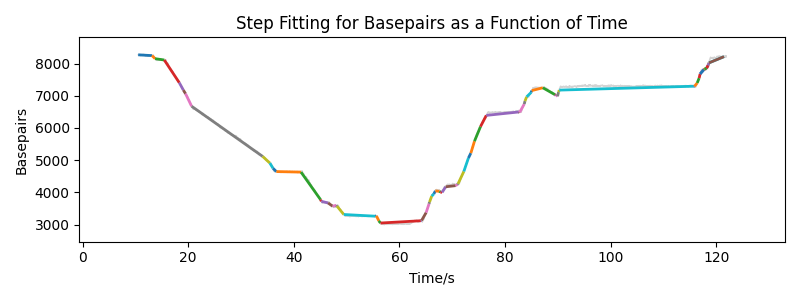

In [40]:
cp_startTime = np.array(bp_time[data_ChangePoint['cp_startIndex']])
cp_endTime = np.array(bp_time[data_ChangePoint['cp_endIndex']])
cp_startBasepair = np.array(bp[data_ChangePoint['cp_startIndex']])
cp_endBasepair = np.array(bp[data_ChangePoint['cp_endIndex']])
cp_data = np.stack((cp_startTime, cp_startBasepair, cp_endTime, cp_endBasepair)).T
cp_data = cp_data.reshape (len(cp_startTime),4)
cp_data = cp_data.reshape((cp_data.shape[0], 2, 2))
segments = tuple(map(tuple, cp_data))
# print(segments)
colors = [mcolors.to_rgba(c)
          for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]

lc = mc.LineCollection(segments, colors=colors, linewidths=2)
fig, ax = plt.subplots(figsize=(8,3))
plt.plot(bp_time,bp,'lightgrey',linewidth = 1)
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
plt.xlabel("Time/s")
plt.ylabel("Basepairs")
plt.title("Step Fitting for Basepairs as a Function of Time")
plt.tight_layout()
plt.show()
plt.savefig(kymo_filename.replace('.tdms', '-cycle')+ kymo_cycle + '-Step Fitting for Basepairs'+'.png', dpi=150)

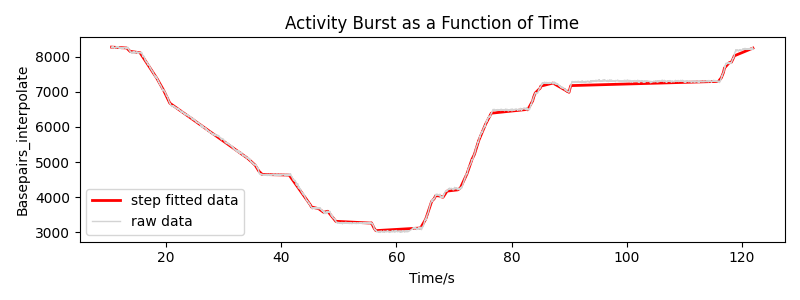

In [41]:
from scipy.interpolate import interp1d

cp_Time = np.append(cp_startTime,cp_endTime[-1])
cp_Basepair = np.append(cp_startBasepair, cp_endBasepair[-1])

# Create DataFrame from your data
df = pd.DataFrame({"cp_Time": cp_Time, "cp_Basepair": cp_Basepair})

# Drop duplicate rows based on both 'cp_Time' and 'cp_Basepair' 
df.drop_duplicates(subset=['cp_Time', 'cp_Basepair'], inplace=True)

cp_Time_unique = df['cp_Time'].to_numpy()
cp_Basepair_unique = df['cp_Basepair'].to_numpy()

# Now use the unique values for interpolation
set_interp = interp1d(cp_Time_unique, cp_Basepair_unique, kind='slinear', fill_value="extrapolate")
cp_basepair_interp = set_interp(bp_time)

plt.figure(figsize=(8,3))
# plt.plot(cp_Time,cp_Basepair,"*-")
plt.plot(bp_time,cp_basepair_interp,"red", label = "step fitted data",linewidth = 2)
plt.plot(bp_time,bp,"lightgrey",label = "raw data",linewidth = 1)
plt.legend()
plt.xlabel("Time/s")
plt.ylabel("Basepairs_interpolate")
plt.title("Activity Burst as a Function of Time")
plt.tight_layout()
plt.show()
plt.savefig(kymo_filename.replace('.tdms', '-cycle')+ kymo_cycle + '-Activity Burst as a Function of Time'+'.png', dpi=150)

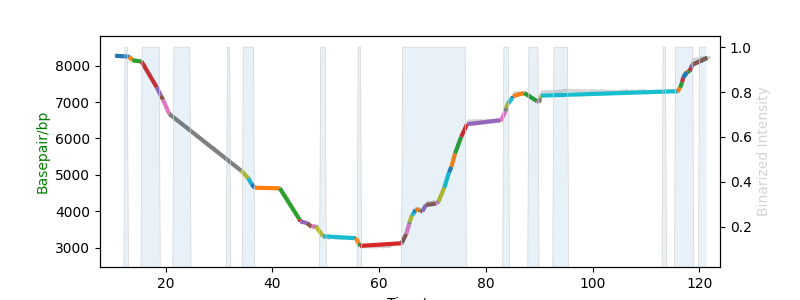

In [42]:
# this code block is intended to overlap the basepair-time and binarized intensity -time plots [ref. https://matplotlib.org/2.0.2/examples/axes_grid/demo_parasite_axes2.html]
basepair = pd.read_excel(trace_file)
bp_time = basepair['time']/1000
bp_time = bp_time.dropna()
bp = basepair['basepairs']
bp = bp.dropna()

fig, ax1 = plt.subplots(figsize=(8,3))

ax2 = ax1.twinx()
ax1.plot(bp_time,bp, 'lightgrey',label = 'basepairs',linewidth=1.5)
colors = [mcolors.to_rgba(c)
          for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
lc = mc.LineCollection(segments, colors=colors, linewidths=3)
ax1.add_collection(lc)
ax1.autoscale()
ax1.margins(0.1)


ax2.plot(x1[:-2],signal_filter_binarized,color='lightgray',linewidth=0.5, label='binarized intensity')
ax2.set_ylim(0.02,1.05)
ax2.fill_between(x1[:-2],signal_filter_binarized, 0, alpha=0.1)
# ax2.plot(x1-0.2,data_stepfinder['FinalFit'],color='black',linewidth=0.1, label='step-like intensity')
# ax2.set_ylim(5,110)
plt.axhline(np.average(bagrnd_signal_filter)+3*np.std(bagrnd_signal_filter), color='grey', linestyle='--',label='3 sigma threshold')
plt.axhline(np.average(bagrnd_signal_filter)-3*np.std(bagrnd_signal_filter), color='grey', linestyle='--')

ax1.set_xlabel('Time/s')
# ax1.set_ylim(4500,9000)
ax1.set_ylabel('Basepair/bp', color='g')
ax2.set_ylabel('Binarized Intensity', color='lightgray')

# plt.plot(bp_time,bp,'y',linewidth = 1, label = 'basepairs')
# plt.plot(x1,signal_filter_binarized, label='Binarized Intensity')
# plt.legend()
# plt.ylim(25,85)
plt.xlim((kymo_xlim_left-x_offset_optimal)/x_cali,(kymo_xlim_right-x_offset_optimal)/x_cali)
# plt.xlim(35,70)
plt.show()
plt.tight_layout()
# plt.savefig(kymo_path + '-cycle' + kymo_cycle + '-basepairs+Binarized intensity'+'.png', dpi=150)

In [43]:
# Save all the analyzed data in an excel file and the analysis log 
excel_filename = kymo_filename.replace('.tdms', '-cycle') + kymo_cycle + "-correlated_data" + '.xlsx'
# no idea why it causes errors without this step
writer = pd.ExcelWriter(excel_filename)

data1 = {'time/s':bp_time,
        'raw_basepair':bp}
data2 = {'cp_startTime/s':cp_startTime,
         'cp_endTime/s':cp_endTime,
         'cp_startBasepair':cp_startBasepair,
        'cp_endBasepair':cp_endBasepair}
data3 = {'time/s':bp_time,
        'cp_basepair':cp_basepair_interp}
data4 = {'time/s':x1[:-2],
        'step_intensity':data_stepfinder['FinalFit']}
data5 = {'time/s':x1[:-2],
        'binarized_intensity':signal_filter_binarized}


df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)
df4 = pd.DataFrame(data4)
df5 = pd.DataFrame(data5)


df1.to_excel(writer,sheet_name ='raw_basepair')
df2.to_excel(writer,sheet_name ='changing_point')
df3.to_excel(writer,sheet_name ='cp_basepair')
df4.to_excel(writer,sheet_name ='step_intensity')
df5.to_excel(writer,sheet_name ='binarized_intensity')


writer.save()

/var/folders/7s/4zb5dg7n24q8rnf1200rm98r0000gn/T/ipykernel_4672/2450148466.py:34: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [44]:
# Save all the analysis parameters in the analysis log in .txt format
analysis_log_data = {"kymo_cycle": kymo_cycle,
                     "kymo_xlim_left":kymo_xlim_left,
                     "kymo_xlim_right":kymo_xlim_right,
                     "x_offset":x_offset_optimal,
                     "y_offset ":y_offset_optimal,
                     "rec_x":rec_x,
                     "rec_y":rec_y,
                     "rec_w":rec_w,
                     "rec_h":rec_h,
                     "bagrnd_filter_window":bagrnd_filter_window,
                     "signal_filter_window":signal_filter_window,
                     "threshold_sigma":threshold_sigma,
                    "Intensity_changepoint#":'134',
                    "windowsize_cp_basepaire":"4",
                    "sigmavalue_basepair":"0.04"}

# "Intensity_changepoint" is the number of changing point for step fitting of intensity (from the first matlab running code)
# "windowsize_cp_basepaire" and "sigmavalue_basepair" are from the second matlab running code

with open(excel_filename[:-20]+ '-analysis_log_data' + '.txt', 'w') as text_file:
    print(analysis_log_data, file=text_file)